# 1. Load & Concatenate

In [12]:
import pandas as pd
import glob
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Try different file patterns to ensure we find all relevant files
patterns = ['HRDH_*/*_joined.csv']
all_files = []

for pattern in patterns:
    files = glob.glob(pattern)
    all_files.extend(files)
    
print(f"Found {len(all_files)} files: {all_files}")

# Read and tag each
df_list = []
for fp in all_files:
    well = Path(fp).parent.name
    print(f"Loading {well} from {fp}")
    df = pd.read_csv(fp)
    df['Well'] = well
    df_list.append(df)

# Concatenate
if df_list:
    all_wells = pd.concat(df_list, axis=0)
    all_wells.reset_index(drop=True, inplace=True)
    print(f"\nTotal samples: {len(all_wells)}")
    print("\nSamples per well:")
    print(all_wells['Well'].value_counts())
else:
    print("No files found! Check file paths.")

Found 4 files: ['HRDH_1119\\HRDH_1119_joined.csv', 'HRDH_1804\\HRDH_1804_joined.csv', 'HRDH_1867\\HRDH_1867_joined.csv', 'HRDH_697\\HRDH_697_joined.csv']
Loading HRDH_1119 from HRDH_1119\HRDH_1119_joined.csv
Loading HRDH_1804 from HRDH_1804\HRDH_1804_joined.csv
Loading HRDH_1867 from HRDH_1867\HRDH_1867_joined.csv
Loading HRDH_697 from HRDH_697\HRDH_697_joined.csv

Total samples: 78

Samples per well:
Well
HRDH_1804    41
HRDH_1119    18
HRDH_697     10
HRDH_1867     9
Name: count, dtype: int64


# 2. Data Quality Assessment



Columns with missing values:
Lab_XRD_Ankerite       9
Lab_XRD_Smectite       9
Lab_XRD_Kaolinite      9
Lab_XRD_Chlorite       9
Lab_XRD_Anhydrite      9
                      ..
Lab_XRD_Anhydrit e    69
Lab_XRD_Halite        69
Lab_XRD_Hematit e     69
Log_CNL               69
Log_CHT.I             68
Length: 63, dtype: int64


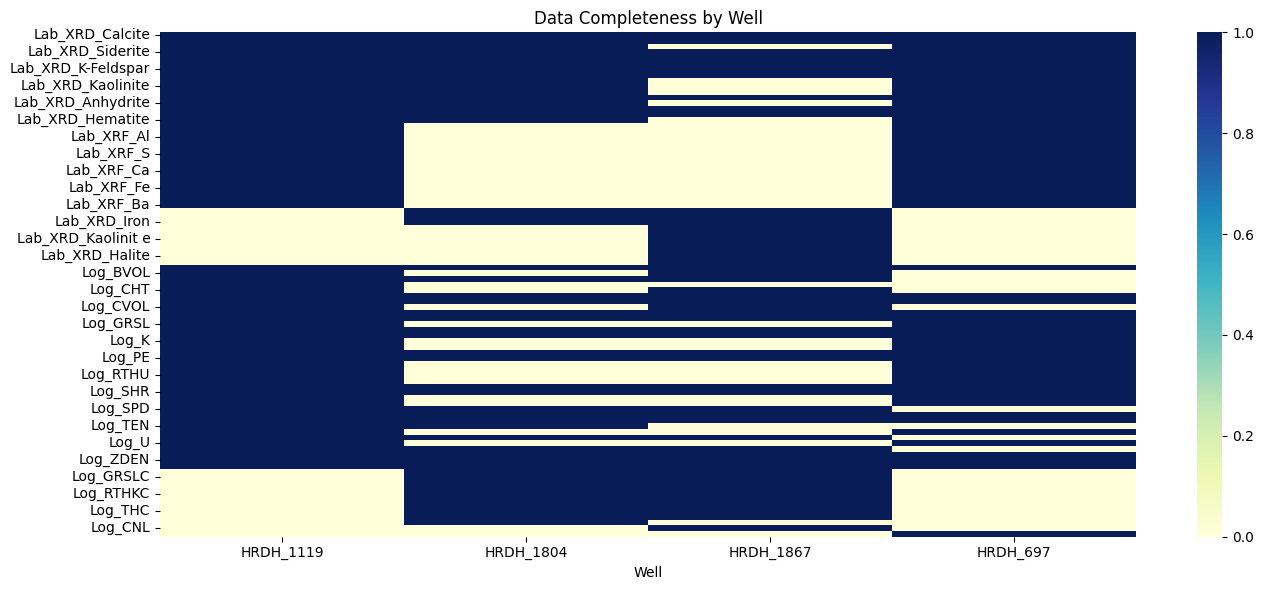

In [13]:
# Check for missing values
missing = all_wells.isnull().sum()
print("\nColumns with missing values:")
print(missing[missing > 0])

# Categorize variables
lab_vars = [c for c in all_wells.columns if c.startswith('Lab_') and c not in ['Lab_Depth', 'Lab_Sample_ID']]
log_vars = [c for c in all_wells.columns if c.startswith('Log_') and c != 'Log_Depth']
depth_vars = ['Lab_Depth', 'Log_Depth']
match_vars = ['Distance', 'Match_Type']

# Data completeness by well
completeness = all_wells.groupby('Well')[lab_vars + log_vars].count() / all_wells.groupby('Well').size().values.reshape(-1, 1)
plt.figure(figsize=(14, 6))
sns.heatmap(completeness.T, cmap='YlGnBu', vmin=0, vmax=1)
plt.title('Data Completeness by Well')
plt.tight_layout()
plt.show()

# 3. Mineral Composition Analysis

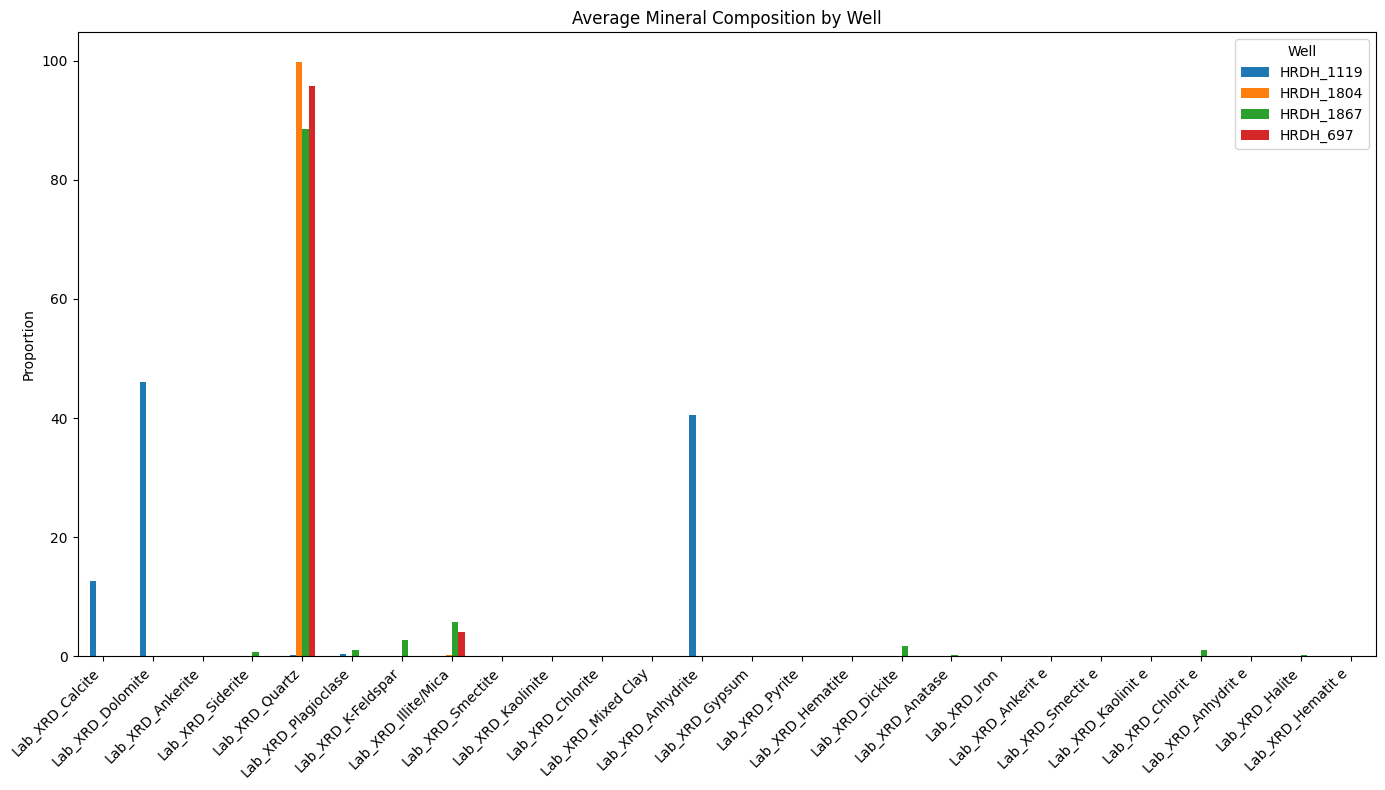

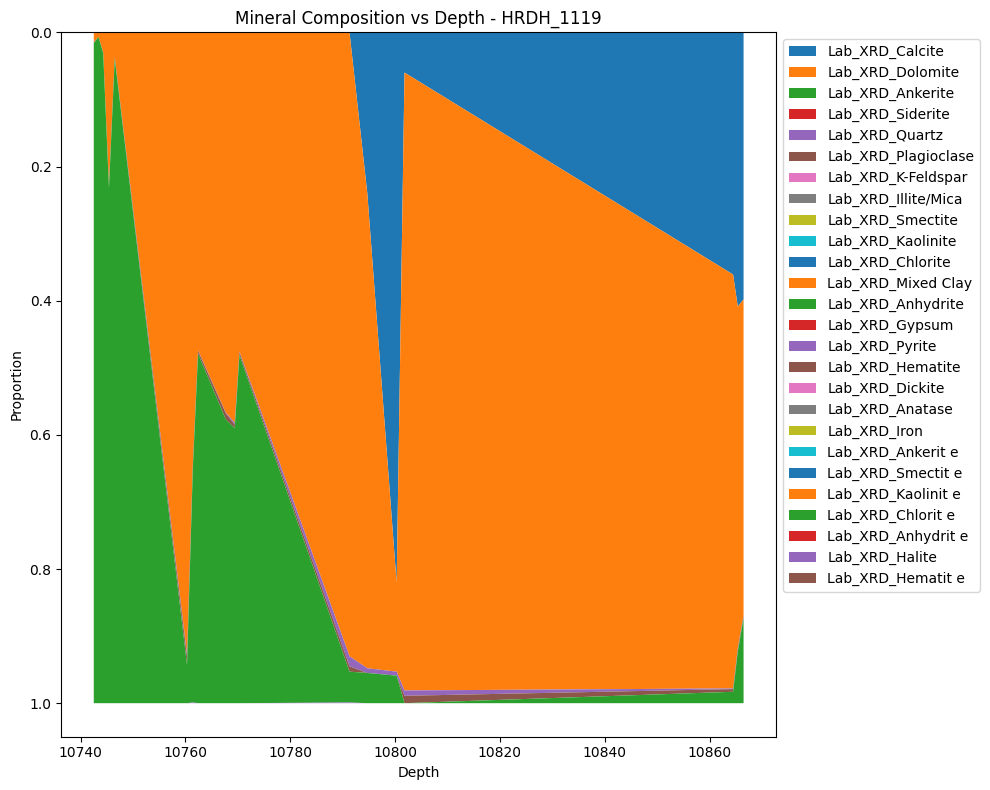

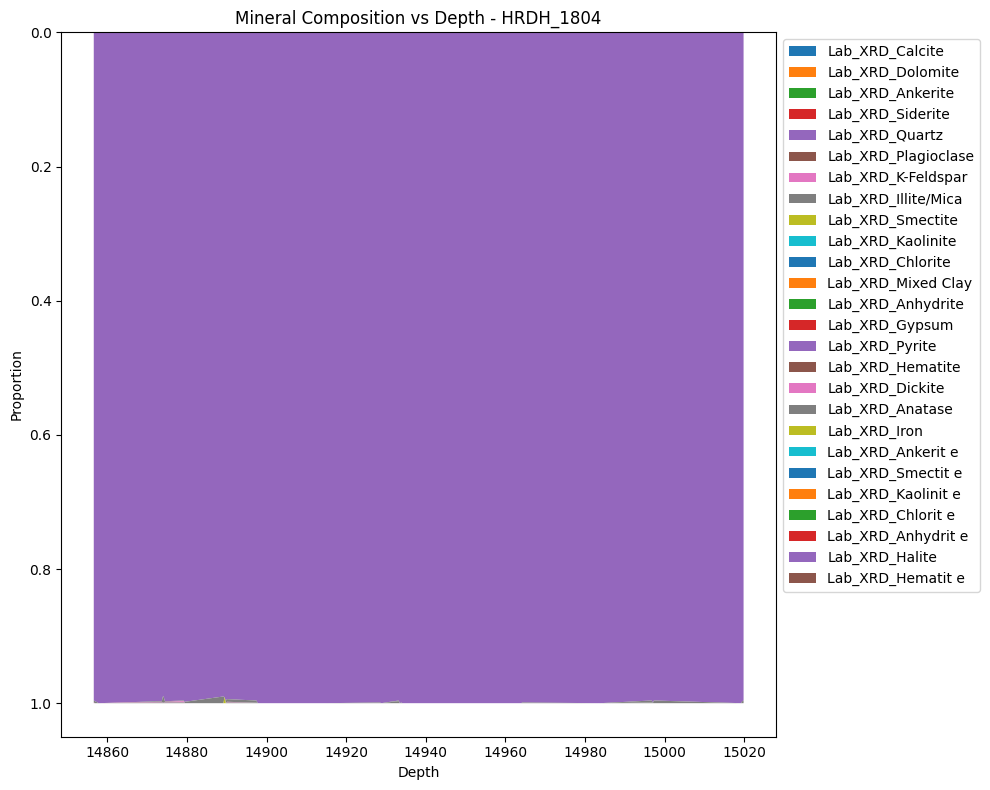

In [14]:
# Extract mineral columns
mineral_cols = [c for c in lab_vars if 'XRD' in c]

# Calculate average mineral composition by well
mineral_avg = all_wells.groupby('Well')[mineral_cols].mean()

# Plot average mineral composition
plt.figure(figsize=(14, 8))
mineral_avg.T.plot(kind='bar', ax=plt.gca())
plt.title('Average Mineral Composition by Well')
plt.ylabel('Proportion')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Well')
plt.tight_layout()
plt.show()

# Stacked area chart of mineral composition vs depth for each well
for well, data in all_wells.groupby('Well'):
    if len(data) > 10:  # Only plot if enough data points
        data = data.sort_values('Lab_Depth')
        # Calculate proportions
        data_norm = data[mineral_cols].div(data[mineral_cols].sum(axis=1), axis=0)
        
        plt.figure(figsize=(10, 8))
        plt.stackplot(data['Lab_Depth'], 
                     [data_norm[col] for col in mineral_cols],
                     labels=mineral_cols)
        plt.title(f'Mineral Composition vs Depth - {well}')
        plt.xlabel('Depth')
        plt.ylabel('Proportion')
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.gca().invert_yaxis()  # Invert y-axis to show increasing depth downward
        plt.tight_layout()
        plt.show()

# 4. Cross-Well Correlation Comparison

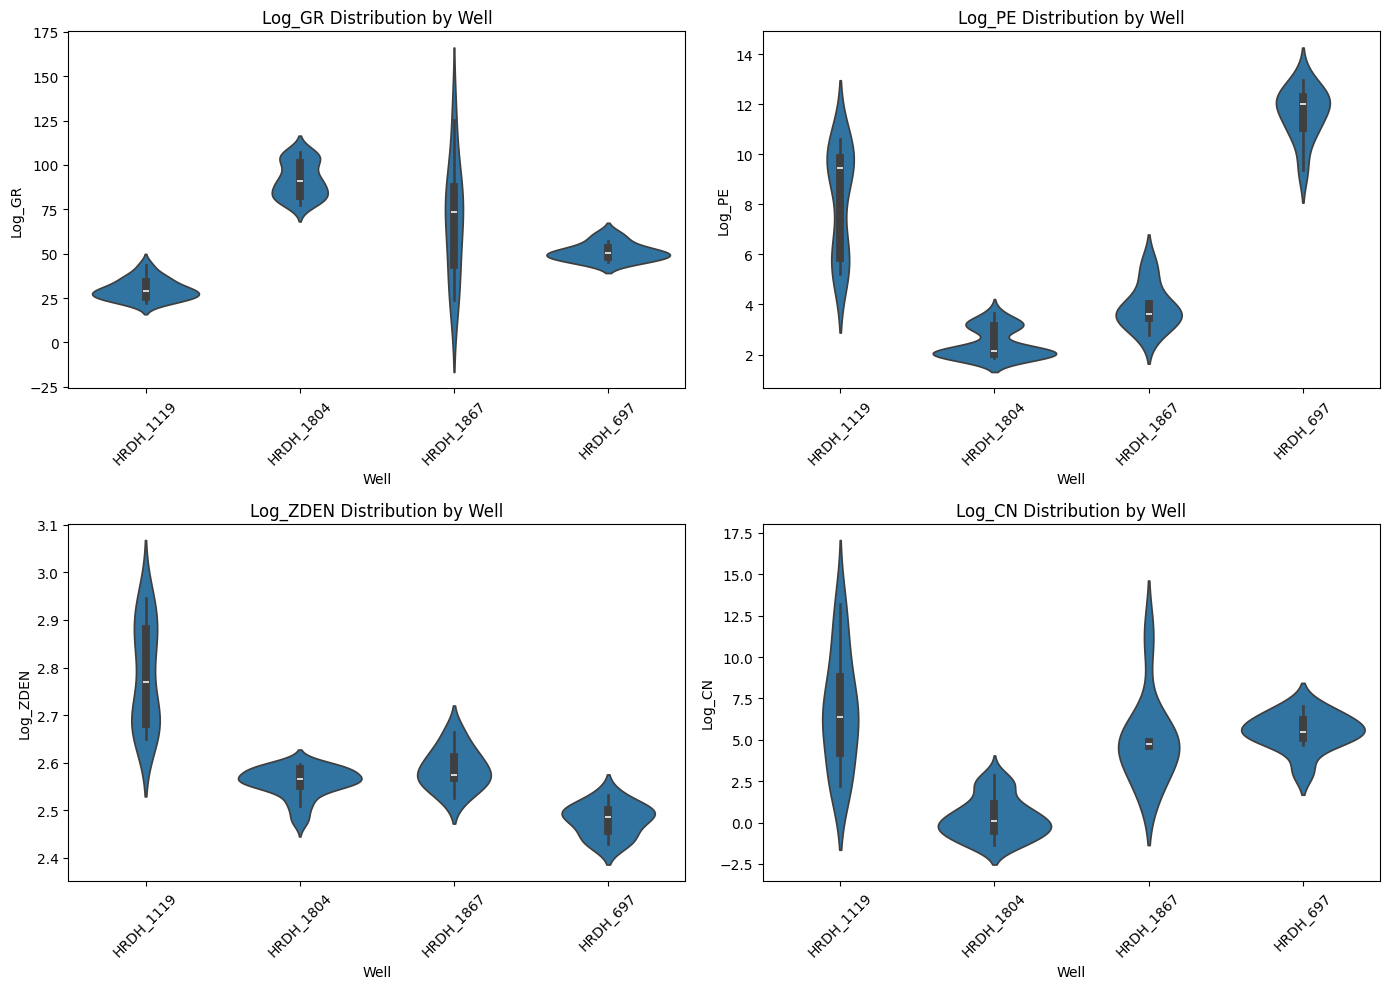

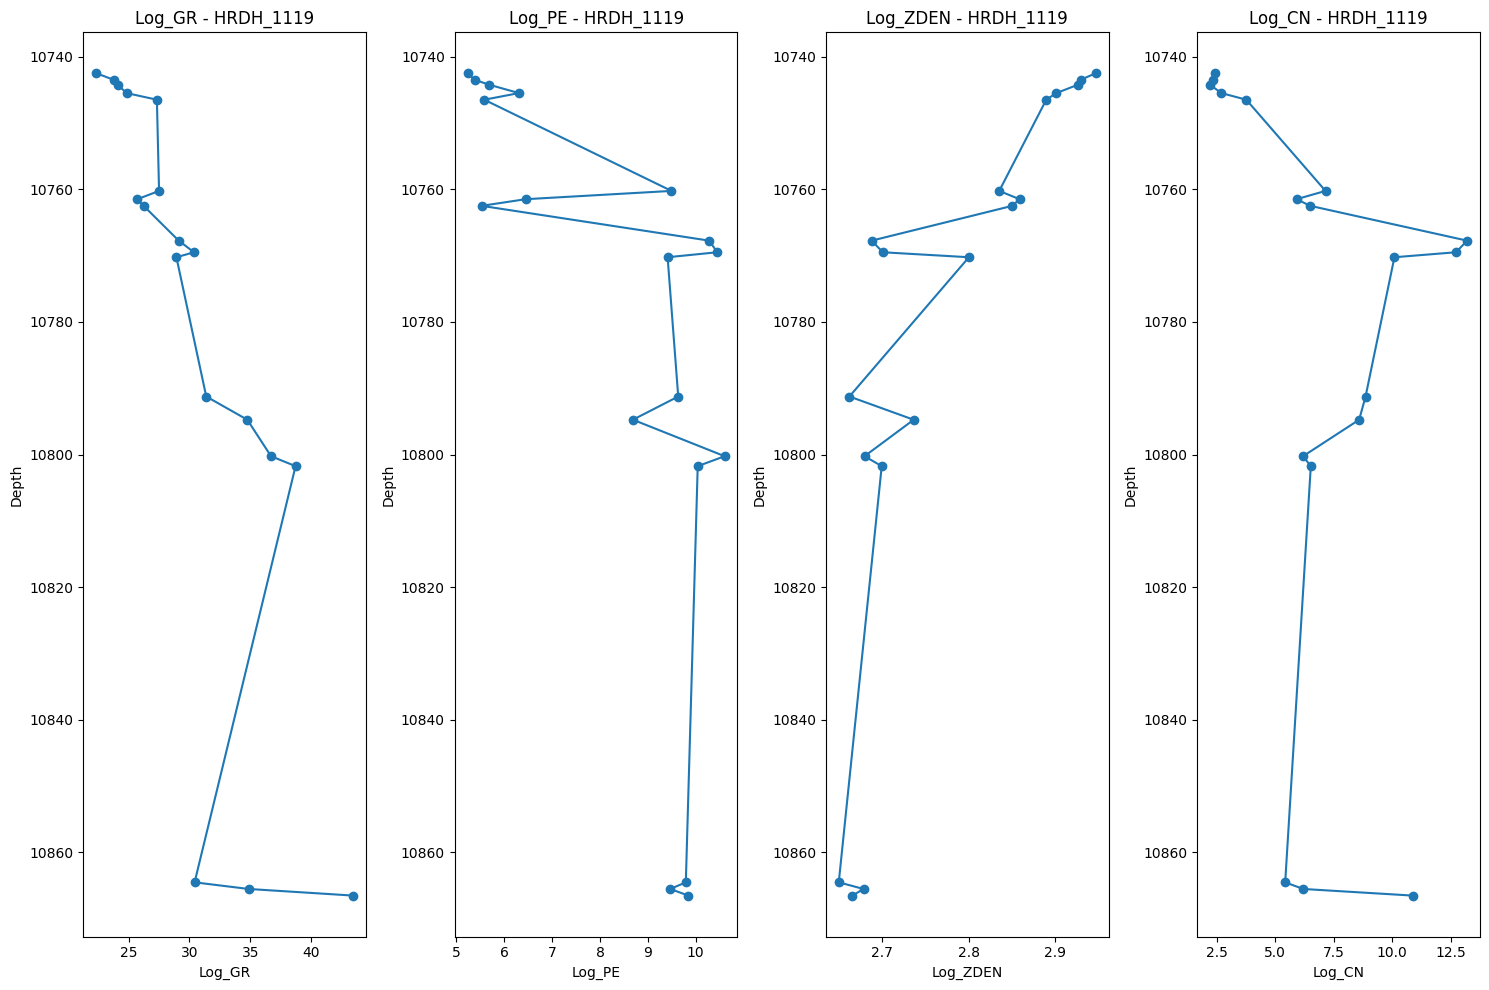

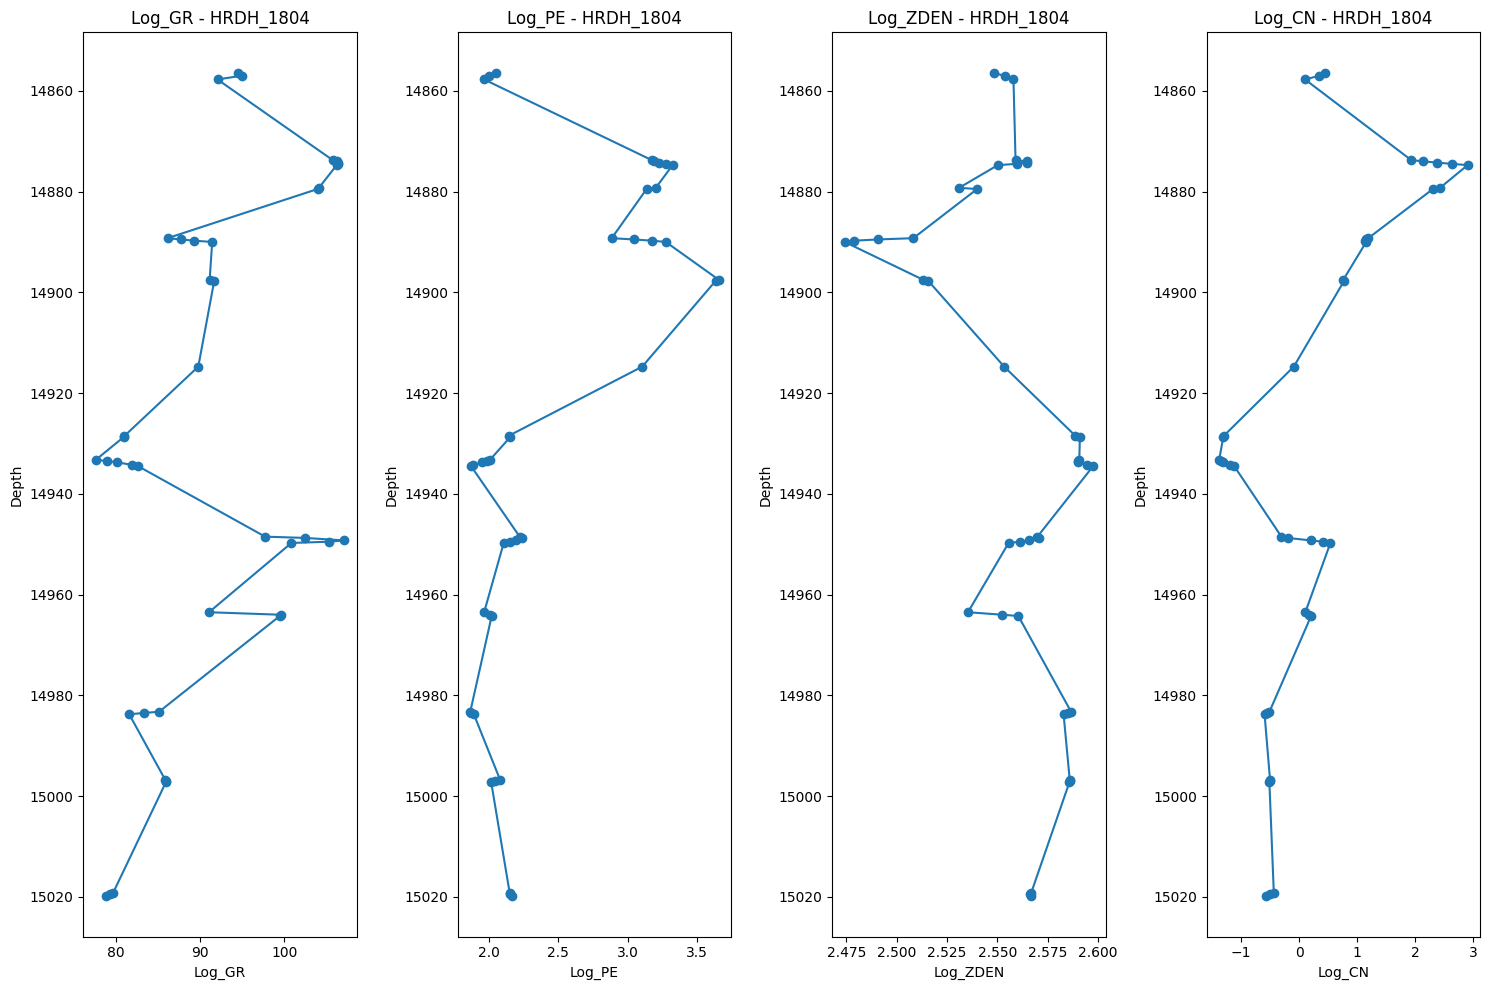

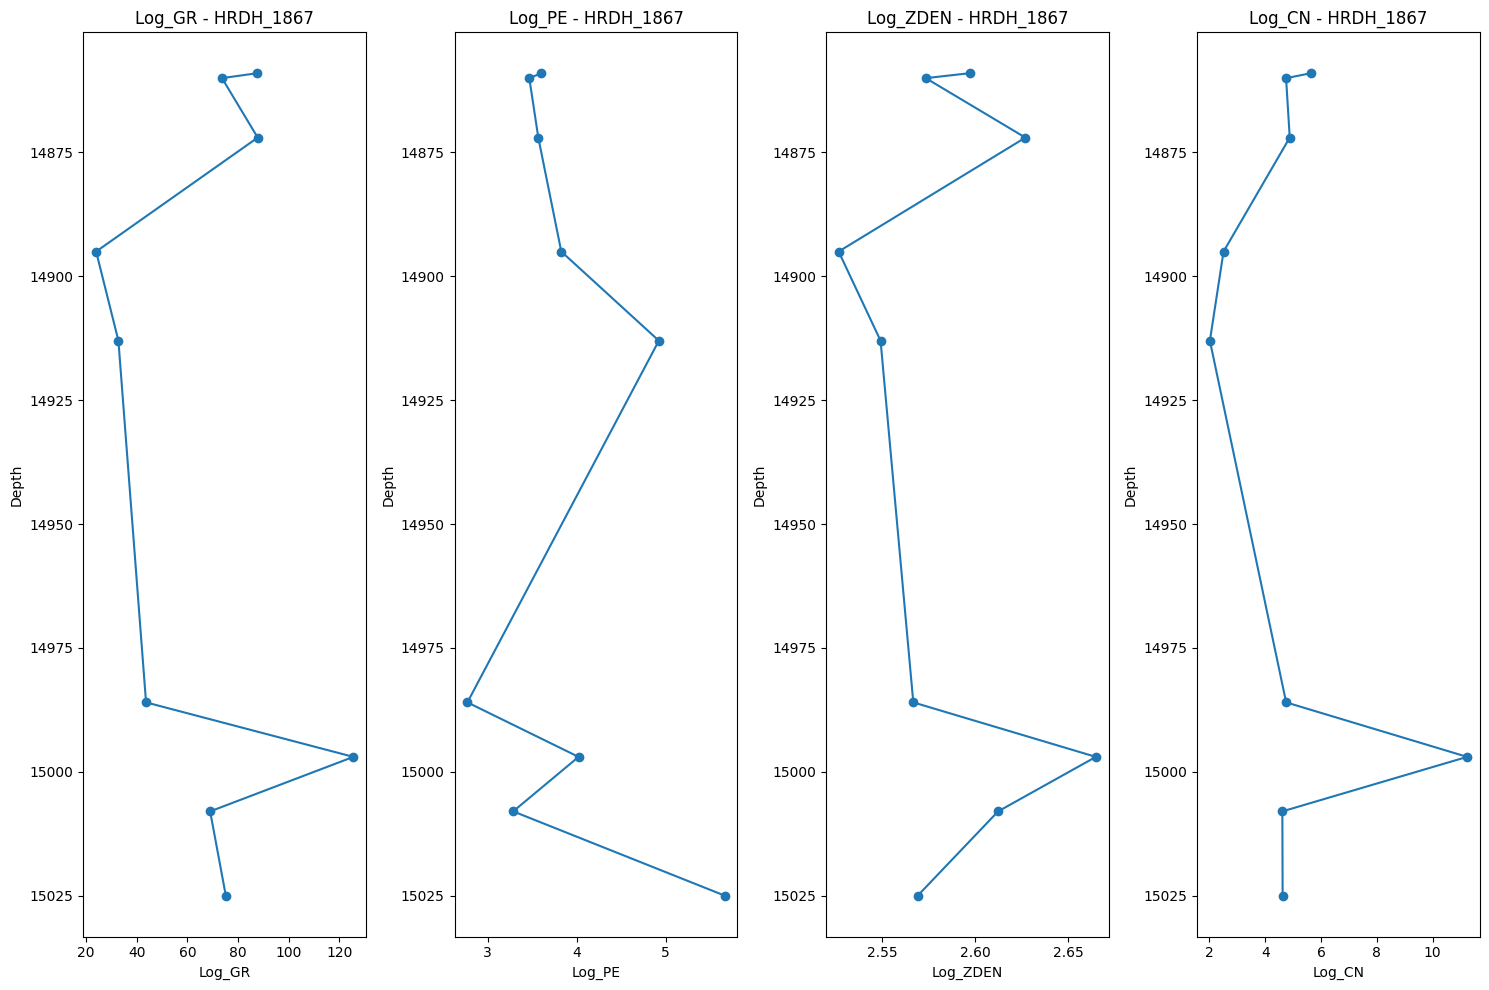

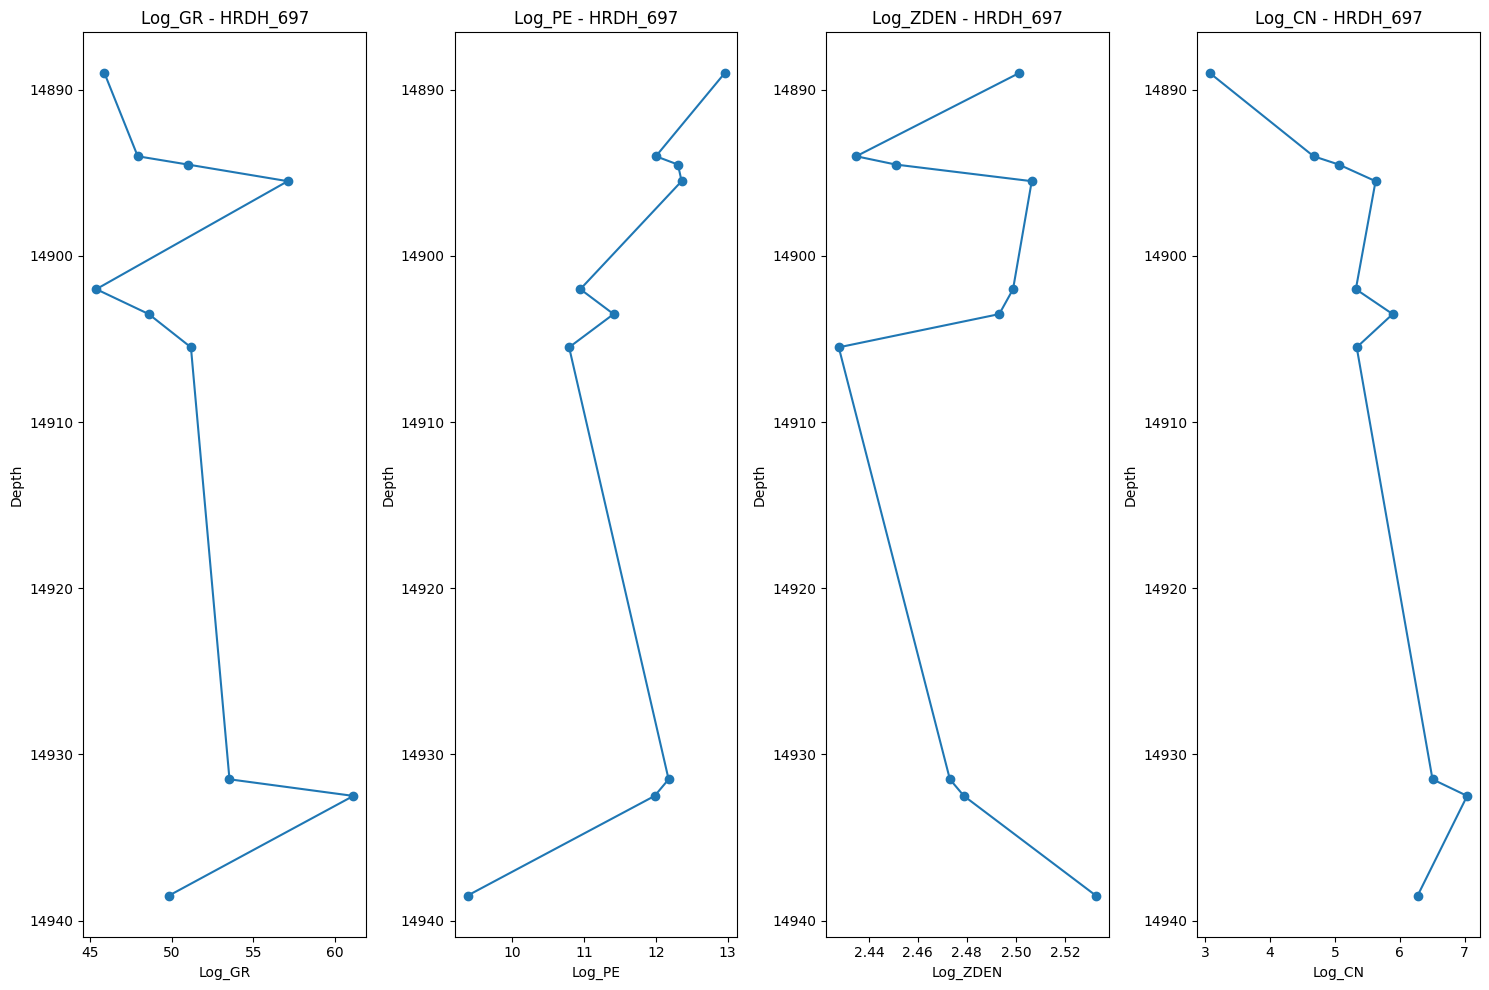

In [15]:
# Select key log properties for comparison
key_logs = ['Log_GR', 'Log_PE', 'Log_ZDEN', 'Log_CN']
key_logs = [log for log in key_logs if log in all_wells.columns]

# Violin plots for distribution comparison
plt.figure(figsize=(14, 10))
for i, log in enumerate(key_logs):
    plt.subplot(2, 2, i+1)
    sns.violinplot(x='Well', y=log, data=all_wells)
    plt.title(f'{log} Distribution by Well')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Depth trends of key logs
for well, data in all_wells.groupby('Well'):
    plt.figure(figsize=(15, 10))
    data = data.sort_values('Log_Depth')
    
    for i, log in enumerate(key_logs):
        if log in data.columns:
            plt.subplot(1, len(key_logs), i+1)
            plt.plot(data[log], data['Log_Depth'], '-o')
            plt.title(f'{log} - {well}')
            plt.xlabel(log)
            plt.ylabel('Depth')
            plt.gca().invert_yaxis()
    
    plt.tight_layout()
    plt.show()

# 5. Advanced: Cluster Wells by Pattern

In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Select numerical columns for PCA
num_cols = lab_vars + log_vars

# Prepare data for PCA
pca_df = all_wells[num_cols + ['Well']].dropna()
if len(pca_df) > 10:  # Only perform PCA if enough complete rows
    X = pca_df[num_cols]
    X_scaled = StandardScaler().fit_transform(X)
    
    # Perform PCA
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(X_scaled)
    pca_result = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
    pca_result['Well'] = pca_df['Well'].values
    
    # Plot PCA results
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='PC1', y='PC2', hue='Well', data=pca_result, s=100)
    plt.title('PCA of Well Data')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Feature importance in PCA
    components = pd.DataFrame(pca.components_.T, index=num_cols, columns=['PC1', 'PC2'])
    plt.figure(figsize=(12, 8))
    sns.heatmap(components, cmap='coolwarm', center=0)
    plt.title('Feature Contributions to Principal Components')
    plt.tight_layout()
    plt.show()
else:
    print("Not enough complete data rows for PCA")

Not enough complete data rows for PCA


# Lab-Log Correlation Analysis


Analyzing correlations for well: HRDH_1119 (18 samples)
Using 17 lab variables and 34 log variables after filtering


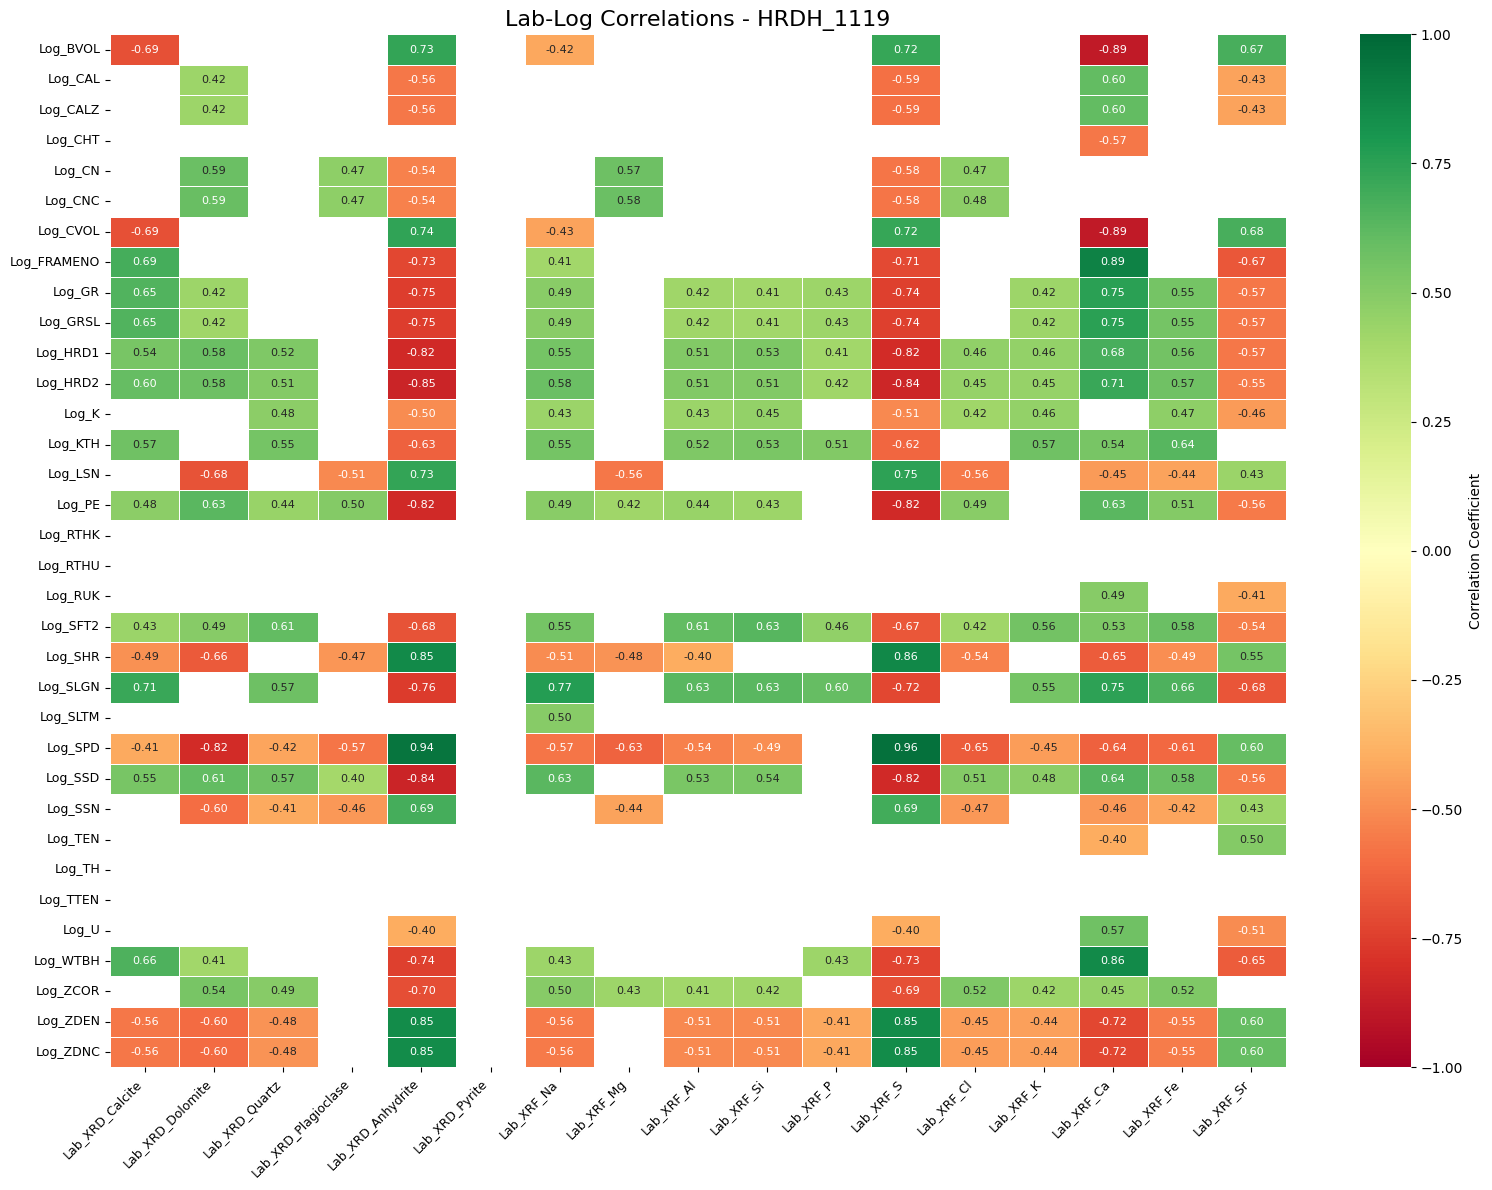


Top correlations:
     Log Variable Lab Variable  Correlation
        Lab_XRF_S      Log_SPD        0.960
Lab_XRD_Anhydrite      Log_SPD        0.939
       Lab_XRF_Ca     Log_CVOL        0.888
       Lab_XRF_Ca     Log_BVOL        0.888
       Lab_XRF_Ca  Log_FRAMENO        0.887
        Lab_XRF_S      Log_SHR        0.861
       Lab_XRF_Ca     Log_WTBH        0.859
Lab_XRD_Anhydrite      Log_SHR        0.854
Lab_XRD_Anhydrite     Log_ZDNC        0.850
Lab_XRD_Anhydrite     Log_ZDEN        0.850

Analyzing correlations for well: HRDH_1804 (41 samples)
Using 5 lab variables and 30 log variables after filtering


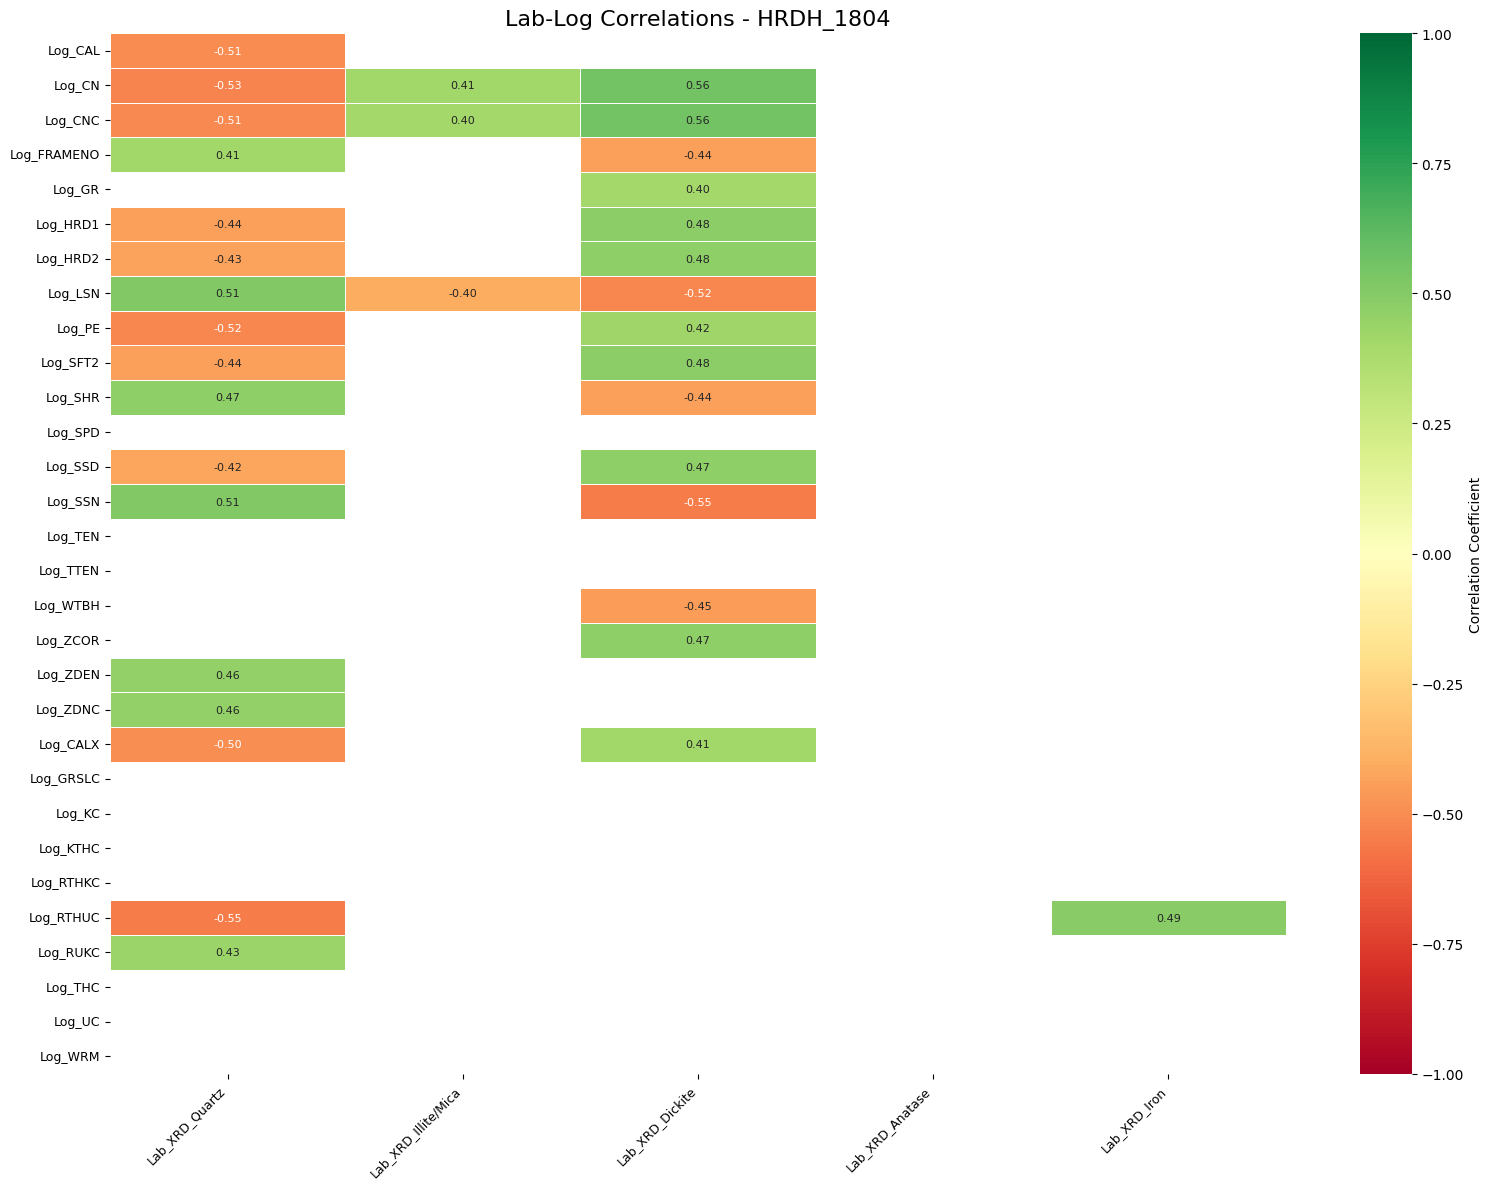


Top correlations:
   Log Variable Lab Variable  Correlation
Lab_XRD_Dickite       Log_CN        0.560
Lab_XRD_Dickite      Log_CNC        0.556
 Lab_XRD_Quartz    Log_RTHUC        0.550
Lab_XRD_Dickite      Log_SSN        0.548
 Lab_XRD_Quartz       Log_CN        0.527
 Lab_XRD_Quartz       Log_PE        0.522
Lab_XRD_Dickite      Log_LSN        0.522
 Lab_XRD_Quartz      Log_LSN        0.513
 Lab_XRD_Quartz      Log_CNC        0.513
 Lab_XRD_Quartz      Log_SSN        0.509

Analyzing correlations for well: HRDH_1867 (9 samples)
Using 9 lab variables and 32 log variables after filtering


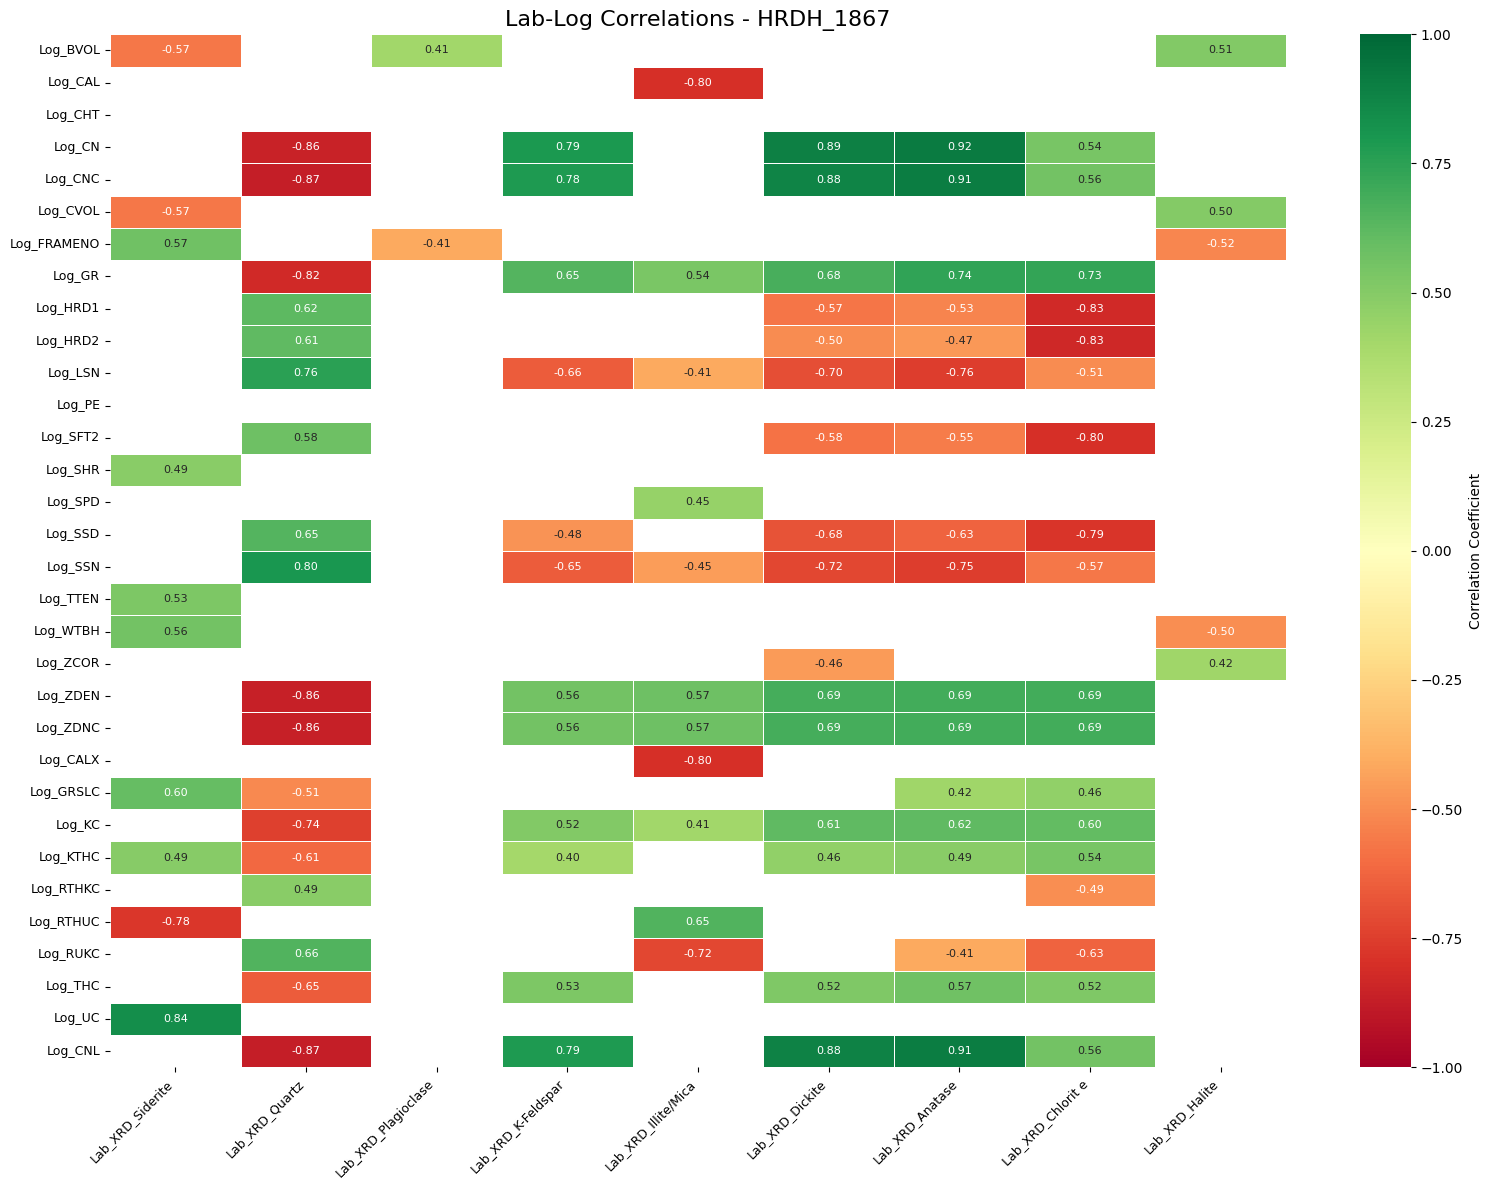


Top correlations:
   Log Variable Lab Variable  Correlation
Lab_XRD_Anatase       Log_CN        0.918
Lab_XRD_Anatase      Log_CNL        0.911
Lab_XRD_Anatase      Log_CNC        0.910
Lab_XRD_Dickite       Log_CN        0.893
Lab_XRD_Dickite      Log_CNL        0.883
Lab_XRD_Dickite      Log_CNC        0.882
 Lab_XRD_Quartz      Log_CNC        0.872
 Lab_XRD_Quartz      Log_CNL        0.871
 Lab_XRD_Quartz     Log_ZDNC        0.862
 Lab_XRD_Quartz     Log_ZDEN        0.862

Analyzing correlations for well: HRDH_697 (10 samples)
Using 17 lab variables and 26 log variables after filtering


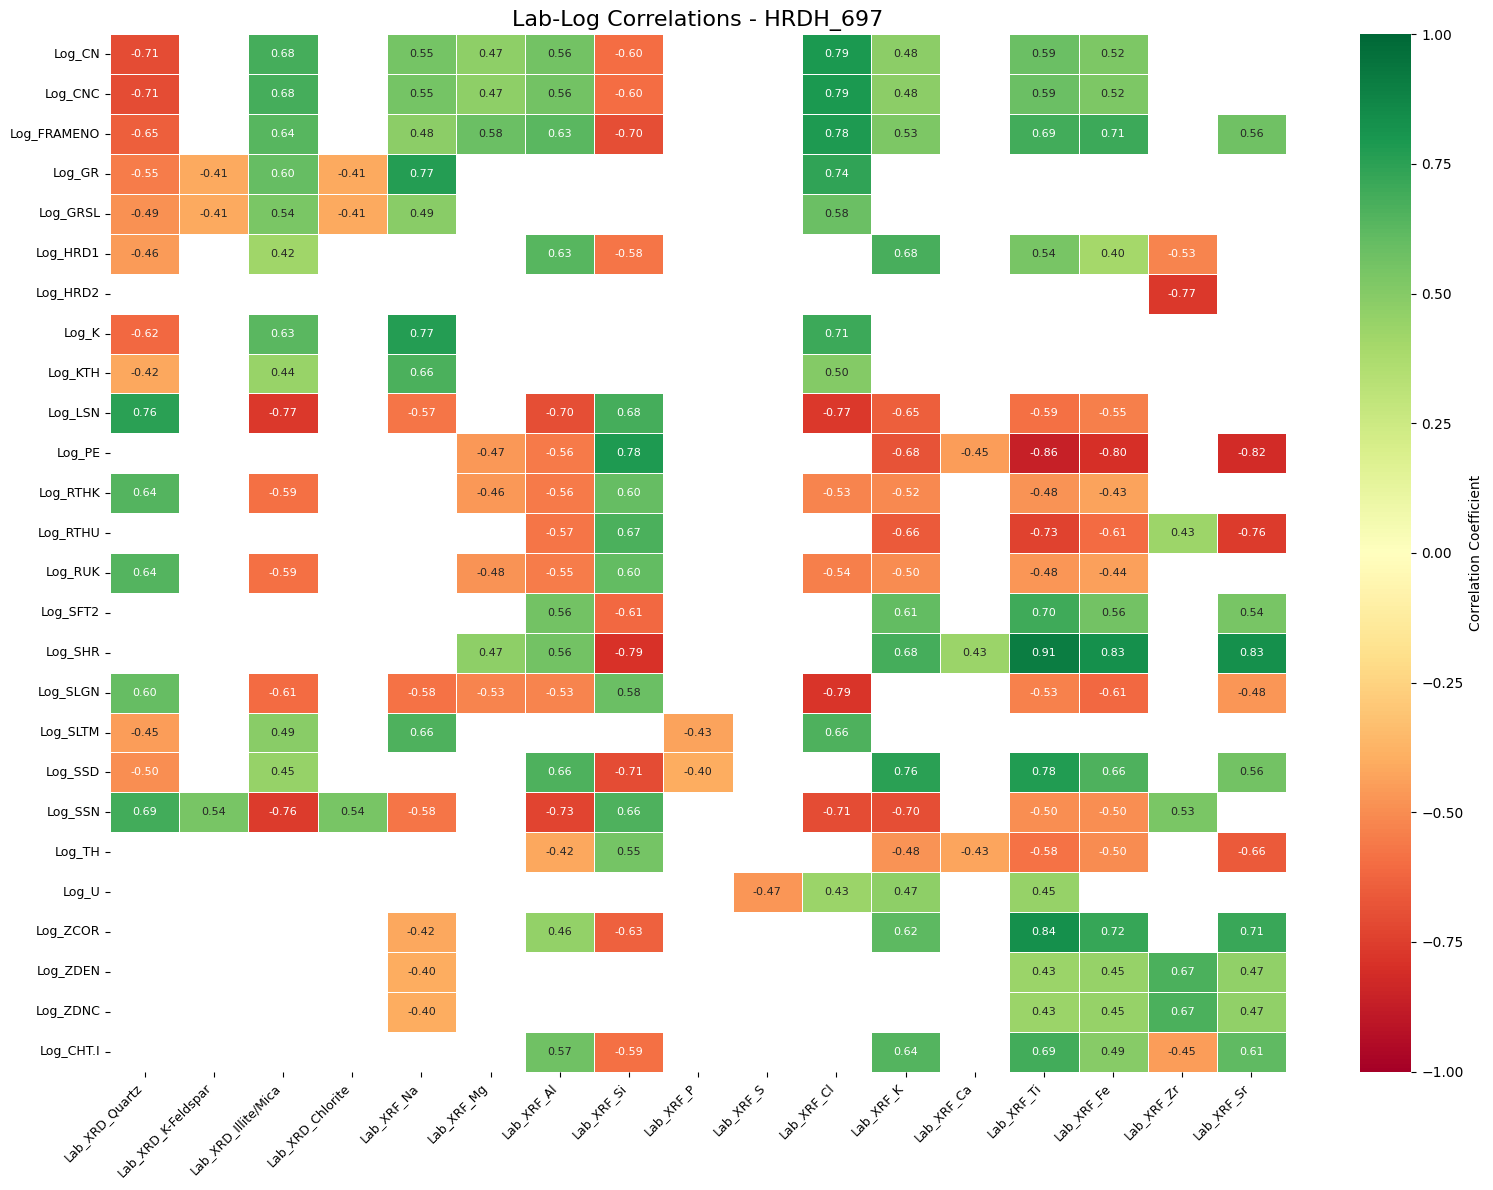


Top correlations:
Log Variable Lab Variable  Correlation
  Lab_XRF_Ti      Log_SHR        0.909
  Lab_XRF_Ti       Log_PE        0.862
  Lab_XRF_Ti     Log_ZCOR        0.836
  Lab_XRF_Fe      Log_SHR        0.831
  Lab_XRF_Sr      Log_SHR        0.830
  Lab_XRF_Sr       Log_PE        0.818
  Lab_XRF_Fe       Log_PE        0.797
  Lab_XRF_Si      Log_SHR        0.792
  Lab_XRF_Cl      Log_CNC        0.790
  Lab_XRF_Cl       Log_CN        0.790


Comparison of key correlations across wells:
Found 3 correlation pairs that appear in multiple wells


KeyError: "None of [Index(['Lab_XRD_Dickite', 'Log_CN'], dtype='object')] are in the [index]"

In [26]:
# Lab-Log Correlation Analysis with improved error handling
def analyze_correlations(all_wells, lab_vars, log_vars, min_corr=0.5):
    """
    Analyzes correlations between lab and log variables across wells.
    
    Parameters:
    - all_wells: DataFrame containing well data
    - lab_vars: List of laboratory measurement columns
    - log_vars: List of log measurement columns
    - min_corr: Minimum correlation value to highlight (absolute value)
    """
    # Store all well correlations for comparison
    well_correlations = {}
    top_correlations_by_well = {}
    
    # Analyze each well separately
    for well, data in all_wells.groupby('Well'):
        # Skip wells with too few samples
        if len(data) < 5:
            print(f"Skipping {well}: insufficient samples ({len(data)})")
            continue
            
        print(f"\n{'='*50}\nAnalyzing correlations for well: {well} ({len(data)} samples)\n{'='*50}")
        
        # Filter out zero/constant/NaN columns for this well
        filtered_lab_vars = [col for col in lab_vars if not (data[col] == 0).all() and not data[col].isna().all()]
        filtered_lab_vars = [col for col in filtered_lab_vars if data[col].std() > 0]
        
        filtered_log_vars = [col for col in log_vars if not (data[col] == 0).all() and not data[col].isna().all()]
        filtered_log_vars = [col for col in filtered_log_vars if data[col].std() > 0]
        
        print(f"Using {len(filtered_lab_vars)} lab variables and {len(filtered_log_vars)} log variables after filtering")
        
        # Calculate correlation matrix between lab and log variables
        corr = data[filtered_lab_vars + filtered_log_vars].corr().loc[filtered_log_vars, filtered_lab_vars]
        well_correlations[well] = corr
        
        # Plot heatmap with improved readability
        plt.figure(figsize=(16, 12))
        mask = np.abs(corr) < min_corr  # Mask weak correlations
        
        # Use a more readable colormap with better contrast
        sns.heatmap(corr, cmap='RdYlGn', vmin=-1, vmax=1, center=0, 
                   annot=True, fmt='.2f', mask=mask, 
                   linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'},
                   annot_kws={'size': 8})  # Smaller font for correlation values
        
        plt.title(f'Lab-Log Correlations - {well}', fontsize=16)
        plt.xticks(rotation=45, ha='right', fontsize=9)
        plt.yticks(fontsize=9)
        plt.tight_layout()
        plt.show()
        
        # Identify and display top correlations in a more structured way
        corr_flat = corr.unstack()
        top_corr = corr_flat.abs().sort_values(ascending=False).head(10)
        top_correlations_by_well[well] = top_corr
        
        # Format output as a table
        print("\nTop correlations:")
        corr_table = pd.DataFrame({
            'Log Variable': [idx[0] for idx in top_corr.index],
            'Lab Variable': [idx[1] for idx in top_corr.index],
            'Correlation': top_corr.values
        })
        print(corr_table.to_string(index=False, float_format=lambda x: f"{x:.3f}"))
    
    # Cross-well correlation comparison (for common pairs)
    if len(well_correlations) >= 2:
        print("\n\nComparison of key correlations across wells:")
        
        # Find correlation pairs from each well's top correlations
        all_pairs = []
        for well, corr_data in top_correlations_by_well.items():
            all_pairs.extend([(idx[0], idx[1]) for idx in corr_data.index])
        
        # Count frequency of each pair across wells
        from collections import Counter
        pair_counts = Counter(all_pairs)
        
        # Only use pairs that appear in at least 2 wells
        common_pairs = [pair for pair, count in pair_counts.items() if count >= 2]
        
        if not common_pairs:
            print("No common correlation pairs found across wells.")
            return well_correlations
            
        print(f"Found {len(common_pairs)} correlation pairs that appear in multiple wells")
        
        # Create comparison DataFrame
        comparison = pd.DataFrame(index=common_pairs, columns=well_correlations.keys())
        
        # Fill in correlation values where available
        for pair in common_pairs:
            log_var, lab_var = pair
            for well, corr_df in well_correlations.items():
                # Check if both variables exist in this well's correlation matrix
                if log_var in corr_df.index and lab_var in corr_df.columns:
                    comparison.loc[pair, well] = corr_df.loc[log_var, lab_var]
                else:
                    comparison.loc[pair, well] = np.nan
        
        # Create readable index labels
        comparison.index = [f"{log_var} vs {lab_var}" for log_var, lab_var in comparison.index]
        
        # Display table of correlation comparisons
        print(comparison.head(15).to_string(float_format=lambda x: f"{x:.3f}" if not pd.isna(x) else "N/A"))
        
        # Visualize comparison of top correlations across wells
        # Only include pairs with data for at least half of the wells
        min_wells_required = len(well_correlations) // 2 + 1
        top_common = comparison.dropna(thresh=min_wells_required).head(8)
        
        if not top_common.empty:
            # IMPROVED VISUALIZATION - larger figure and better formatting
            plt.figure(figsize=(14, 10))
            
            # Enhanced heatmap with RdYlGn colormap and better sizing
            sns.heatmap(top_common.T, 
                       cmap='RdYlGn',        # Changed to RdYlGn as requested
                       center=0, 
                       annot=True, 
                       fmt='.2f',
                       annot_kws={'size': 12},  # Larger annotation text
                       linewidths=1,           # Thicker cell borders
                       square=True)            # Square cells for better readability
            
            plt.title('Comparison of Key Correlations Across Wells', fontsize=16)
            plt.ylabel('Well', fontsize=14)
            plt.xlabel('Correlation Pair', fontsize=14)
            plt.xticks(rotation=45, ha='right', fontsize=12)
            plt.yticks(fontsize=12)
            plt.tight_layout()
            plt.show()
        else:
            print("Not enough common correlations to create visualization")
    
    return well_correlations


# Run the correlation analysis
correlations = analyze_correlations(all_wells, lab_vars, log_vars, min_corr=0.4)

# Lithology Classification


<Figure size 1200x600 with 0 Axes>

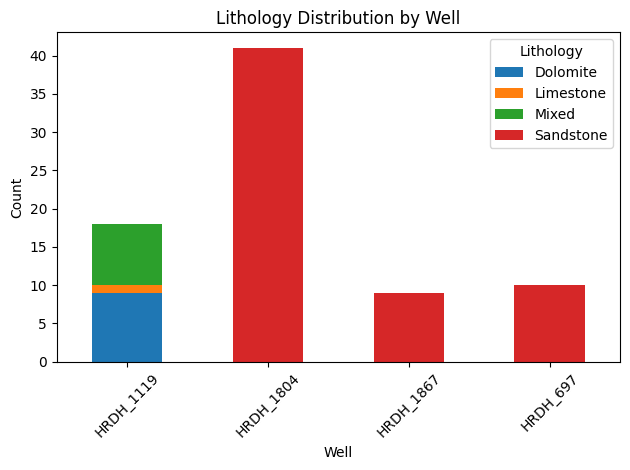

In [19]:
# Simple lithology classification based on mineral content
def classify_lithology(row):
    # Example classification rules (customize based on your geology)
    if row['Lab_XRD_Calcite'] > 50:
        return 'Limestone'
    elif row['Lab_XRD_Dolomite'] > 50:
        return 'Dolomite'
    elif row['Lab_XRD_Quartz'] > 50:
        return 'Sandstone'
    elif row['Lab_XRD_Illite/Mica'] + row.get('Lab_XRD_Smectite', 0) + row.get('Lab_XRD_Kaolinite', 0) > 50:
        return 'Shale'
    else:
        return 'Mixed'

# Apply classification if mineral columns exist
mineral_cols = [c for c in all_wells.columns if 'XRD' in c]
if len(mineral_cols) > 0:
    try:
        all_wells['Lithology'] = all_wells.apply(classify_lithology, axis=1)
        
        # Plot lithology distribution by well
        plt.figure(figsize=(12, 6))
        lithology_counts = all_wells.groupby(['Well', 'Lithology']).size().unstack().fillna(0)
        lithology_counts.plot(kind='bar', stacked=True)
        plt.title('Lithology Distribution by Well')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.legend(title='Lithology')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not classify lithology: {e}")